# BE 240 Lecture 4
# Sub-SBML 
## Modeling diffusion, shared resources, and compartmentalized systems

## _Ayush Pandey_


In [1]:
# This notebook is designed to be converted to a HTML slide show
# To do this in the command prompt type (in the folder containing the notebook): 
# jupyter nbconvert BE240_Lecture4_Sub-SBML.ipynb --to slides

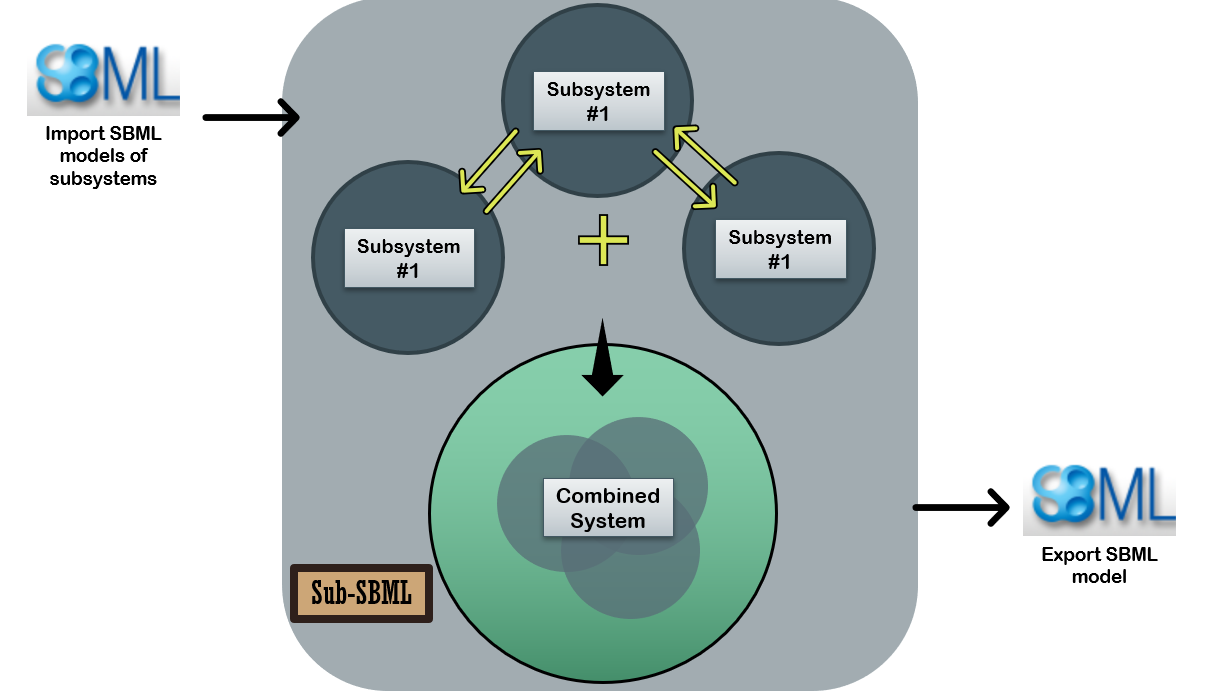

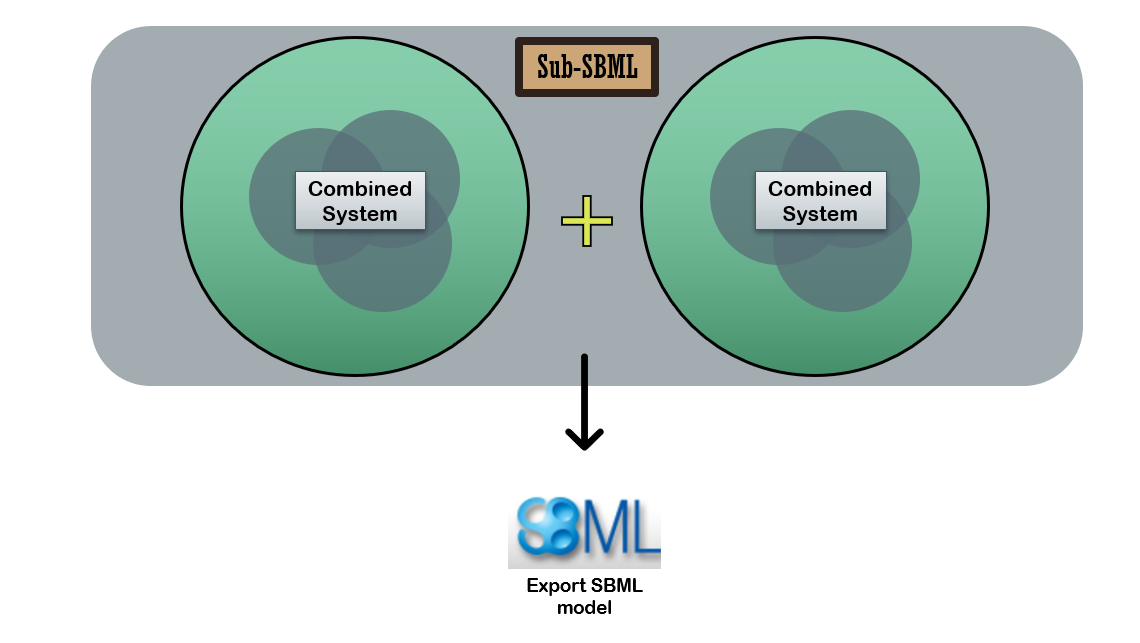

# An example:

### Three different "subsystems" - each with its SBML model
### Another "signal in mixture" subsystem - models signal in the environment / mixture 
### Using Sub-SBML we can obtain the combined model for such a system with
* transport across membrane
* shared resources : ATP, Ribosome etc
* resolve naming conflicts (Ribo, Ribosome, RNAP, RNAPolymerase etc.)


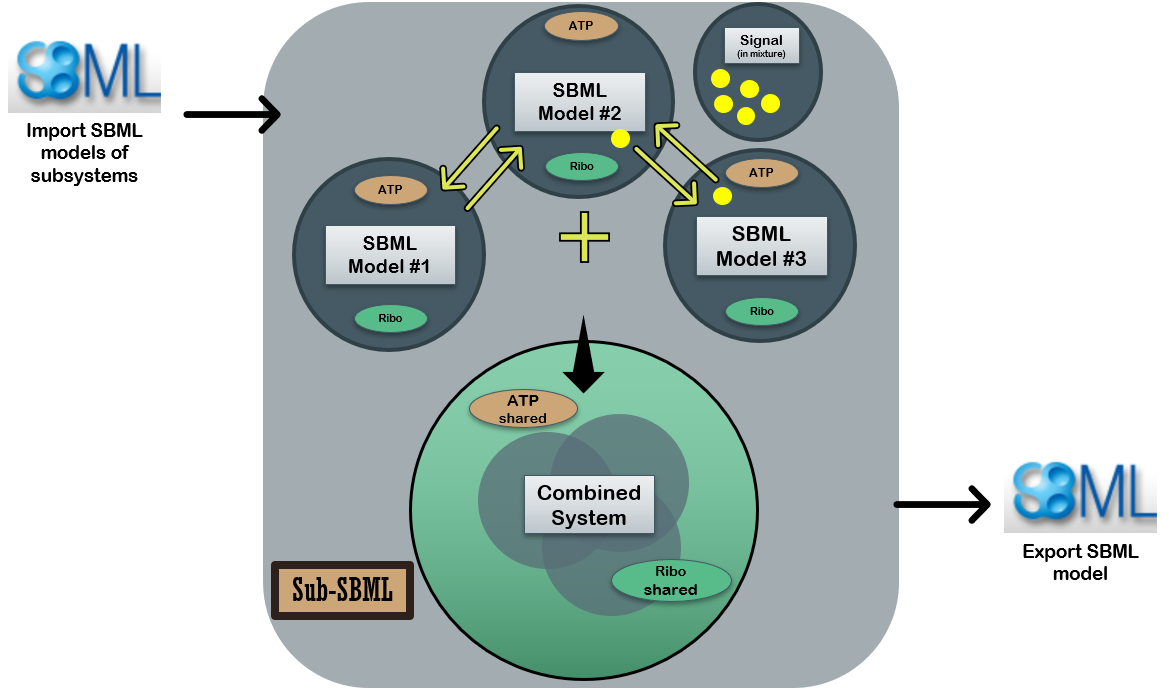

# Installing Sub-SBML

```
git clone https://github.com/BuildACell/subsbml.git
```
cd to `subsbml` directory then run the following command to install the package in your environment:
```
 python setup.py install
```

# Dependencies:
1. python-libsbml : Run `pip install python-libsbml`, if you don't have it already. You probably already have this installed as it is also a dependency for bioscrape
1. A simulator: You will need a simulator of your choice to simulate the SBML models that Sub-SBML generates. Bioscrape is an example of a simulator and we will be using that for simulations.

# Update your bioscrape installation
From the bioscrape directory, run the following if you do not have a remote fork (your own Github fork of the original bioscrape repository - `biocircuits/bioscrape`. To list all remote repositories that your bioscrape directory is connected to you can run `git remote -v`. The `origin` in the next two commands corresponds to the biocircuits/bioscrape github repository (you should change it if your remote has a different name)
```
git pull origin master

python setup.py install
```


Update your BioCRNpyler installation as well - if you plan to use your own BioCRNpyler models with Sub-SBML. Run the same commands as for bioscrape from the BioCRNpyler directory. 


## Sub-SBML notes:

## On "name" and "identifier":
> SBML elements can have a name and an identifier argument. A `name` is supposed to be a human readable name of the particular element in the model. On the other hand, an `identifier` is what the software tool reads. Hence, `identifier` argument in an SBML model is mandatory whereas `name` argument is optional. 

Sub-SBML works with `name` arguments of various model components to figure out what components interact/get combined/shared etc. Bioscrape/BioCRNpyler and other common software tools generate SBML models with `name` arguments added to various components such as species, parameters. As an example, to combine two species, Sub-SBML looks at the names of the two species and if they are the same - they are combined together and given a new identifier but the name remains the same. 

## A simple Sub-SBML use case:

A simple example where we have two different models : transcription and translation. Using Sub-SBML, we can combine these two together and run simulations. 

In [1]:
# Import statements
from subsbml.Subsystem import createNewSubsystem, createSubsystem

import numpy as np
import pylab as plt

## Transcription Model:

Consider the following simple transcription-only model where $G$ is a gene, $T$ is a transcript, and $S$ is the signaling molecule.

We can write the following reduced order dynamics:
1. $G \xrightarrow[]{\rho_{tx}(G, S)} G + T$; 
\begin{align} 
\rho_{tx}(G, S) = G K_{X}\frac{S^{2}}{K_{S}^{2}+S^{2}}
\\
\end{align}
Here, $S$ is the inducer signal that cooperatively activates the transcription of the gene $G$. Since, this is a positive activation of the gene by the inducer, we have a positive proportional Hill function.

1. $T \xrightarrow[]{\delta} \varnothing$; massaction kinetics at rate $\delta$.

## Translation model:

1. $T \xrightarrow[]{\rho_{tl}(T)} T+X$; 
\begin{align} 
\rho_{tl}(T) = K_{TR} \frac{T}{K_{R} + T}
\\
\end{align}
Here $X$ is the protein species.
The lumped parameters $K_{TR}$ and $K_R$ model effects due to ribosome saturation. This is the similar Hill function as derived in the enzymatic reaction example. 

1. $X \xrightarrow[]{\delta} \varnothing$; massaction kinetics at rate $\delta$.

In [2]:
# Import SBML models by creating Subsystem class objects
ss1 = createSubsystem('transcription_SBML_model.xml')
ss2 = createSubsystem('translation_SBML_model.xml')

ss1.renameSName('mRNA_T', 'T')
# Combine the two subsystems together
tx_tl_subsystem = ss1 + ss2

# The longer way to do the same thing: 

# tx_tl_subsystem = createNewSubsystem()
# tx_tl_subsystem.combineSubsystems([ss1,ss2], verbose = True)

# Set signal concentration (input) - manually and get ID for protein X

X_id = tx_tl_subsystem.getSpeciesByName('X').getId()
# Writing a Subsystem to an SBML file (Export SBML)
_ = tx_tl_subsystem.writeSBML('txtl_ss.xml')
tx_tl_subsystem.setSpeciesAmount('S',10)

True

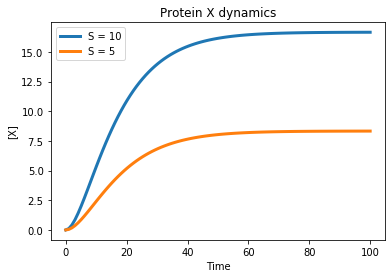

In [3]:
try:
    # Simulate with Bioscrape and plot the result
    timepoints = np.linspace(0,100,100)
    results, _ = tx_tl_subsystem.simulateWithBioscrape(timepoints)
    plt.plot(timepoints, results[X_id], linewidth = 3, label = 'S = 10')
    tx_tl_subsystem.setSpeciesAmount('S',5)
    results, _ = tx_tl_subsystem.simulateWithBioscrape(timepoints)
    plt.plot(timepoints, results[X_id], linewidth = 3, label = 'S = 5')
    plt.title('Protein X dynamics')
    plt.ylabel('[X]')
    plt.xlabel('Time')
    plt.legend()
    plt.show()
except:
    print('Simulator not found')

In [4]:
# Viewing the change log for the changes that Sub-SBML made 

# print(ss1.changeLog)
# print(ss2.changeLog)
print(tx_tl_subsystem.changeLog)

{'default_bioscrape_generated_model_47961': 'default_bioscrape_generated_model_245758_combined', 'default_bioscrape_generated_model_245758': 'default_bioscrape_generated_model_245758_combined', 'mRNA_T_bioscrape_generated_model_245758': 'mRNA_T_bioscrape_generated_model_245758_1_combined', 'T_bioscrape_generated_model_47961': 'mRNA_T_bioscrape_generated_model_245758_1_combined', 'delta_bioscrape_generated_model_245758': 'delta_combined', 'delta_bioscrape_generated_model_47961': 'delta_combined', 'n_bioscrape_generated_model_245758': 'n_combined', 'n_bioscrape_generated_model_47961': 'n_combined'}


## Signal induction model:

1. $\varnothing \xrightarrow[]{\rho(I)} S$; 
\begin{align} 
\rho(S) = K_{0} \frac{I^2}{K_{I} + I^2}
\\
\end{align}
Here $S$ is the signal produced on induction by an inducer $I$.
The lumped parameters $K_{0}$ and $K_S$ model effects of cooperative production of the signal by the inducer. This is the similar Hill function as derived in the enzymatic reaction example. 

In [5]:
ss3 = createSubsystem('signal_in_mixture.xml')

# Signal subsystem (production of signal molecule)
combined_ss = ss1 + ss2 + ss3 

# Alternatively
combined_ss = createNewSubsystem()
combined_ss.combineSubsystems([ss1,ss2,ss3])

# Writing a Subsystem to an SBML file (Export SBML)
combined_ss.writeSBML('txtl_combined.xml')

# Set signal concentration (input) - manually and get ID for protein X
combined_ss.setSpeciesAmount('I',10)
X_id = combined_ss.getSpeciesByName('X').getId()

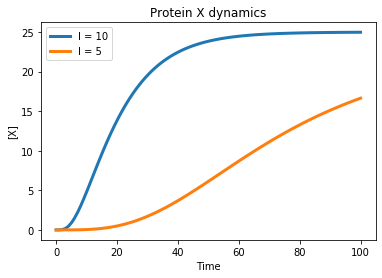

In [6]:
try:
    # Simulate with Bioscrape and plot the result
    timepoints = np.linspace(0,100,100)
    results, _ = combined_ss.simulateWithBioscrape(timepoints)
    plt.plot(timepoints, results[X_id], linewidth = 3, label = 'I = 10')
    combined_ss.setSpeciesAmount('I',2)
    results, _ = combined_ss.simulateWithBioscrape(timepoints)
    plt.plot(timepoints, results[X_id], linewidth = 3, label = 'I = 5')
    plt.title('Protein X dynamics')
    plt.ylabel('[X]')
    plt.xlabel('Time')
    plt.legend()
    plt.show()
except:
    print('Simulator not found')

In [7]:
combined_ss.changeLog

{'default_bioscrape_generated_model_47961': 'default_bioscrape_generated_model_245758_combined',
 'default_bioscrape_generated_model_578081': 'default_bioscrape_generated_model_245758_combined_1',
 'default_bioscrape_generated_model_245758': 'default_bioscrape_generated_model_245758_combined_1',
 'S_bioscrape_generated_model_245758': 'S_bioscrape_generated_model_245758_1_combined',
 'S_bioscrape_generated_model_578081': 'S_bioscrape_generated_model_245758_1_combined',
 'mRNA_T_bioscrape_generated_model_245758': 'mRNA_T_bioscrape_generated_model_245758_1_combined',
 'T_bioscrape_generated_model_47961': 'mRNA_T_bioscrape_generated_model_245758_1_combined',
 'KI_bioscrape_generated_model_245758': 'KI_combined',
 'delta_bioscrape_generated_model_245758': 'delta_combined',
 'delta_bioscrape_generated_model_47961': 'delta_combined',
 'n_bioscrape_generated_model_245758': 'n_combined',
 'n_bioscrape_generated_model_47961': 'n_combined',
 'n_bioscrape_generated_model_578081': 'n_combined'}

## What does Sub-SBML look for?

1. For compartments: if two compartments have the same `name` and the same `size` attributes => they are combined together.
1. For species: if two species have the same `name` attribute => they are combined together. If initial amount is not the same, the first amount is set. It is easy to set species amounts later.
1. For parameters: if two paraemters have the same `name` attribute **and** the same `value` => they are combined together.
1. For reactions: if two reactions have the same `name` **and** the same reaction string (reactants -> products) => they are combined together. 
1. Other SBML components are also merged.

# Utility functions for Subsystems
1. Set `verbose` keyword argument to `True` to get a list of detailed warning messages that describe the changes being made to the models. Helpful in debugging and creating clean models when combining multiple models.
1. Use `renameSName` method for a `Subsystem` to rename any species' names throughout a model and `renameSIdRefs` to rename identifiers.
1. Use `createBasicSubsystem()` function to get a basic "empty" subsystem model.
1. Use `getSpeciesByName` to get all species with a given name in a Subsystem model.
1. use `shareSubsystems` method similar to `combineSubsystems` method if you are only interested in getting a model with shared resource species combined together. 
1. Set `combineNames` keyword argument to `False` in `combineSubsystems` method to combine the Subsystem objects but treating the elements with the same `name` as different.

# Modeling transport across membranes 
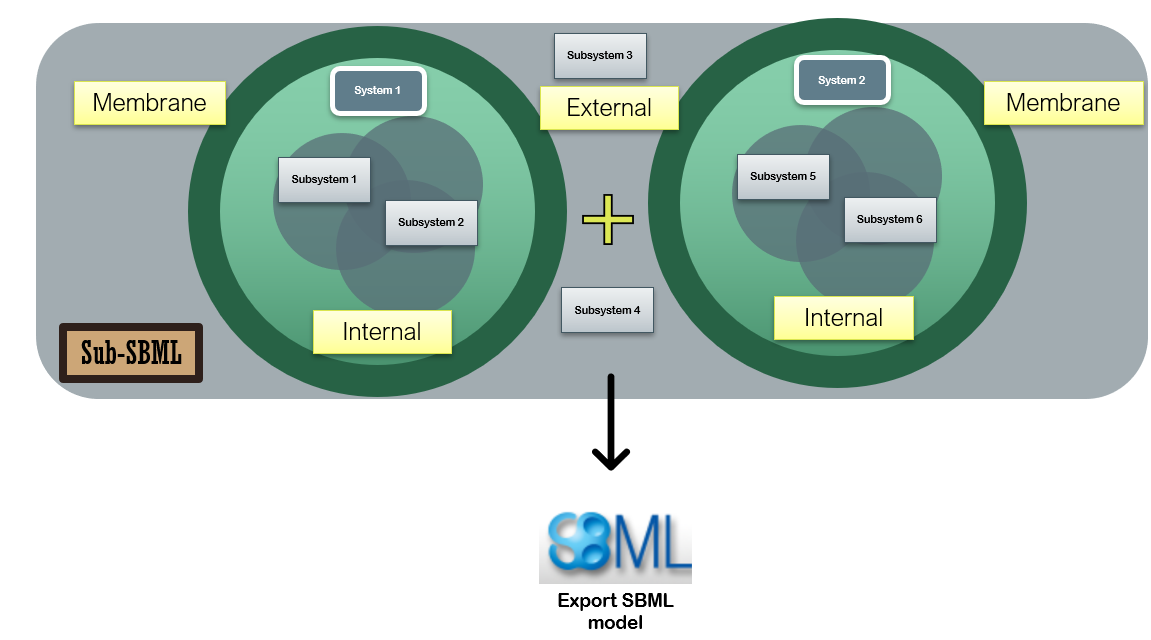

## System 1 : TX-TL with IPTG reservoir and no membrane


In [8]:
from subsbml.System import System, combineSystems

cell_1 = System('cell_1')

ss1 = createSubsystem('txtl_ss.xml')
ss1.renameSName('S', 'IPTG')
ss2 = createSubsystem('IPTG_reservoir.xml')

IPTG_external_conc = ss2.getSpeciesByName('IPTG').getInitialConcentration()

cell_1.setInternal([ss1])
cell_1.setExternal([ss2])
# cell_1.setMembrane() # Membrane-less system
ss1.setSpeciesAmount('IPTG', IPTG_external_conc)

cell_1_model = cell_1.getModel() # Get a Subsystem object that represents the combined model for cell_1
cell_1_model.writeSBML('cell_1_model.xml')

1

## System 2 : TX-TL with IPTG reservoir and a simple membrane

### Membrane : IPTG external and internal diffusion in a one step reversible reaction

In [9]:
from subsbml import System, createSubsystem, combineSystems, createNewSubsystem
ss1 = createSubsystem('txtl_ss.xml')
ss1.renameSName('S','IPTG')
ss2 = createSubsystem('IPTG_reservoir.xml')

# Create a simple IPTG membrane where IPTG goes in an out of the membrane via a reversible reaction
mb2 = createSubsystem('membrane_IPTG.xml', membrane = True)

# cell_2 =  System('cell_2',ListOfInternalSubsystems = [ss1],
#                  ListOfExternalSubsystems = [ss2],
#                  ListOfMembraneSubsystems = [mb2])
cell_2 = System('cell_2')
cell_2.setInternal(ss1)
cell_2.setExternal(ss2)
cell_2.setMembrane(mb2)
cell_2_model = cell_2.getModel()
cell_2_model.setSpeciesAmount('IPTG', 1e4, compartment = 'cell_2_external')
cell_2_model.writeSBML('cell_2_model.xml')

The subsystem from membrane_IPTG.xml has multiple compartments


1

## System 3 : TX-TL with IPTG reservoir and a detailed membrane diffusion

### Membrane : IPTG external binds to a transport protein and forms a complex. This complex causes the diffusion of IPTG in the internal of the cell.

In [10]:
# Create a more detailed IPTG membrane where IPTG binds to an intermediate transporter protein, forms a complex
# then transports out of the cell system to the external environment 

mb3 = createSubsystem('membrane_IPTG_detailed.xml', membrane = True)

cell_3 =  System('cell_3',ListOfInternalSubsystems = [ss1],
                 ListOfExternalSubsystems = [ss2],
                 ListOfMembraneSubsystems = [mb3])
cell_3_model = cell_3.getModel()
cell_3_model.setSpeciesAmount('IPTG', 1e4, compartment = 'cell_3_external')
cell_3_model.writeSBML('cell_3_model.xml')

combined_model = combineSystems([cell_1, cell_2, cell_3])

The subsystem from membrane_IPTG_detailed.xml has multiple compartments


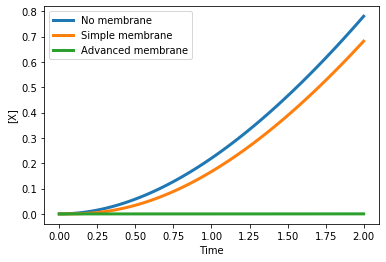

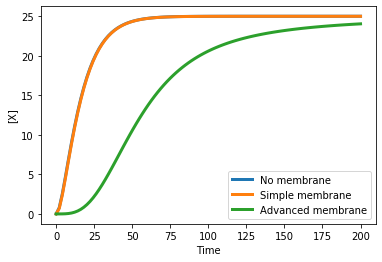

In [11]:
try:
    import numpy as np
    import matplotlib.pyplot as plt
    timepoints = np.linspace(0,2,100)
    results_1, _ = cell_1_model.simulateWithBioscrape(timepoints)
    results_2, _ = cell_2_model.simulateWithBioscrape(timepoints)
    results_3, _ = cell_3_model.simulateWithBioscrape(timepoints)

    X_id1 = cell_1_model.getSpeciesByName('X').getId()
    X_id2 = cell_2_model.getSpeciesByName('X', compartment = 'cell_2_internal').getId()
    X_id3 = cell_3_model.getSpeciesByName('X', compartment = 'cell_3_internal').getId()
    plt.plot(timepoints, results_1[X_id1], linewidth = 3, label = 'No membrane')
    plt.plot(timepoints, results_2[X_id2], linewidth = 3, label = 'Simple membrane')
    plt.plot(timepoints, results_3[X_id3], linewidth = 3, label = 'Advanced membrane')
    plt.xlabel('Time')
    plt.ylabel('[X]')
    plt.legend()
    plt.show()

    timepoints = np.linspace(0,200,100)
    results_1, _ = cell_1_model.simulateWithBioscrape(timepoints)
    results_2, _ = cell_2_model.simulateWithBioscrape(timepoints)
    results_3, _ = cell_3_model.simulateWithBioscrape(timepoints)
    X_id1 = cell_1_model.getSpeciesByName('X').getId()
    X_id2 = cell_2_model.getSpeciesByName('X', compartment = 'cell_2_internal').getId()
    X_id3 = cell_3_model.getSpeciesByName('X', compartment = 'cell_3_internal').getId()
    plt.plot(timepoints, results_1[X_id1], linewidth = 3, label = 'No membrane')
    plt.plot(timepoints, results_2[X_id2], linewidth = 3, label = 'Simple membrane')
    plt.plot(timepoints, results_3[X_id3], linewidth = 3, label = 'Advanced membrane')
    plt.xlabel('Time')
    plt.ylabel('[X]')
    plt.legend()
    plt.show()
except:
    print('Simulator not found')

# Additional Sub-SBML Tools:

* Create SBML models directly using `SimpleModel` class
* Simulate directly using `bioscrape` or `libRoadRunner` with various simulation options
* Various utility functions to edit SBML models:
    1. Change species names/identifiers throughout an SBML model.
    1. Edit parameter values or species initial conditions easily (directly in an SBML model).
* `combineSystems` function can be used to combine multiple `System` objects together as shown in the previous cell. Also, a special use case interaction modeling function is available : `connectSubsystems`. Refer to the tutorial_interconnetion.ipynb notebook in the tutorials directory for more information about this.

# Things to Try:
1. Compartmentalize your own SBML model - generate more than 1 model each with a different compartment names. Using tools in this notebook, try to combine your models together and regenerate the expected simulation.
1. Implement a diffusion model and use it as a membrane model for a `System` of your choice.
1. Implement an even more complicated diffusion model for the above example and run the simulation.
1. **The package has not been tested extensively. So, it would be really great if you could raise [issues](https://github.com/BuildACell/subsbml/issues) on Github if you face any errors with your models. Also, feel free to send a message on Slack channel or DM.**